In [3]:
!pip install opencv-python-headless scikit-learn torch torchvision
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files, drive
drive.mount('/content/drive')  # Optionnel pour sauvegardes

Mounted at /content/drive


In [4]:
dataset_path = '/content/AMHCD_64'

classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

X = []
y = []
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (32, 32))
            img_flat = img_resized.flatten() / 255.0
            X.append(img_flat)
            y.append(class_to_idx[cls])

X = np.array(X)
y = np.array(y)

lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)

np.save('/content/X.npy', X)
np.save('/content/y.npy', y_onehot)
print(f'Données prêtes : {X.shape[0]} images')

Données prêtes : 25740 images


PyTorch Fold 1


/tmp/ipython-input-661844327.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32) / 255.0 # Convert back to tensor and normalize


Epoch 1, Loss: 3.526040799869514
Epoch 2, Loss: 3.526036010025451
Epoch 3, Loss: 3.526032909103062
Epoch 4, Loss: 3.5260276520474356
Epoch 5, Loss: 3.5260320531655545
Epoch 6, Loss: 3.5260265525083363
Epoch 7, Loss: 3.5260383779217737
Epoch 8, Loss: 3.5260353229060675
Epoch 9, Loss: 3.526023104324104
Epoch 10, Loss: 3.526030281315679
Epoch 11, Loss: 3.5260333178206262
Epoch 12, Loss: 3.526037444239077
Epoch 13, Loss: 3.526045520853552
Epoch 14, Loss: 3.52603400568044
Epoch 15, Loss: 3.526021951474018
Epoch 16, Loss: 3.5260272788705294
Epoch 17, Loss: 3.526024428213605
Epoch 18, Loss: 3.526028211072365
Epoch 19, Loss: 3.526040705834857
Epoch 20, Loss: 3.5260320620507186
Accuracy: 0.027389277389277388
PyTorch Fold 2
Epoch 1, Loss: 3.5260771172387257
Epoch 2, Loss: 3.526039350106849
Epoch 3, Loss: 3.5260340552892746
Epoch 4, Loss: 3.526029956266747
Epoch 5, Loss: 3.526018516617532
Epoch 6, Loss: 3.526040476301442
Epoch 7, Loss: 3.526033628801381
Epoch 8, Loss: 3.526019749434098
Epoch 9, L

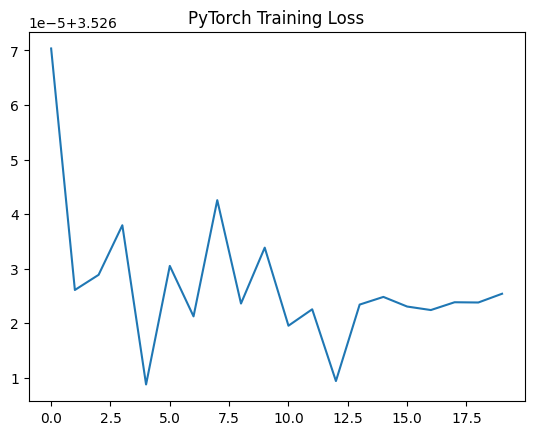

In [7]:
class AMHCDDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].reshape(32, 32)
        if self.transform:
            img = self.transform(img.astype(np.uint8)) # Convert to numpy array and then to uint8
        img = torch.tensor(img, dtype=torch.float32) / 255.0 # Convert back to tensor and normalize
        # Return the class index instead of the one-hot encoded vector
        return img.flatten(), torch.tensor(np.argmax(self.y[idx]), dtype=torch.long)

transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor()
])

class MLP(nn.Module):
    def __init__(self, input_size=1024, hidden1=128, hidden2=64, output_size=34):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

def train_model(model, train_loader, optimizer, criterion, epochs=20, device='cuda'):
    model.to(device)
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    return losses

def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Compare predicted class index with the actual class index
    return correct / total

X = np.load('/content/X.npy')
y = np.load('/content/y.npy')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies_pytorch = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'PyTorch Fold {fold+1}')
    train_dataset = AMHCDDataset(X[train_idx], y[train_idx], transform=transform)
    val_dataset = AMHCDDataset(X[val_idx], y[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

    losses = train_model(model, train_loader, optimizer, criterion, device=device)
    acc = evaluate_model(model, val_loader, device=device)
    accuracies_pytorch.append(acc)
    print(f'Accuracy: {acc}')

print(f'PyTorch Mean Accuracy: {np.mean(accuracies_pytorch)}')

# Plot losses
plt.plot(losses)
plt.title('PyTorch Training Loss')
plt.show()

torch.save(model.state_dict(), '/content/pytorch_model.pth')

TF Fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0298 - loss: 4.1197 - val_accuracy: 0.0274 - val_loss: 3.5279
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.0320 - loss: 3.5186 - val_accuracy: 0.0295 - val_loss: 3.5057
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.0323 - loss: 3.5043 - val_accuracy: 0.0268 - val_loss: 3.5024
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0312 - loss: 3.5022 - val_accuracy: 0.0303 - val_loss: 3.5028
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.0288 - loss: 3.5013 - val_accuracy: 0.0268 - val_loss: 3.5010
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.0281 - loss: 3.4994 - val_accuracy: 0.0319 - val_loss: 3.4988
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0275 - loss: 3.4992 - val_accuracy: 0.0305 - val_loss: 3.5002
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.0301 - loss: 3.4991 - val_accuracy:

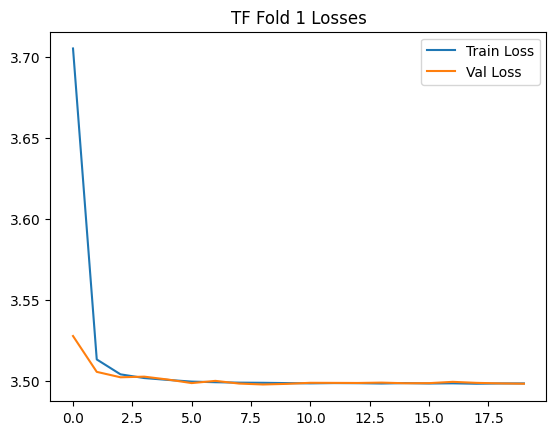

TF Fold 2
Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0282 - loss: 3.9195 - val_accuracy: 0.0282 - val_loss: 3.5150
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0270 - loss: 3.5101 - val_accuracy: 0.0286 - val_loss: 3.5040
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.0285 - loss: 3.5030 - val_accuracy: 0.0299 - val_loss: 3.5018
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.0304 - loss: 3.5013 - val_accuracy: 0.0282 - val_loss: 3.4999
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.0300 - loss: 3.4999 - val_accuracy: 0.0291 - val_loss: 3.4998
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0264 - loss: 3.4998 - val_accuracy: 0.0289 - val_loss: 3.4994
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0316 - loss: 3.4988 - val_accuracy: 0.0346 - val_loss: 3.4977
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0294 - loss: 

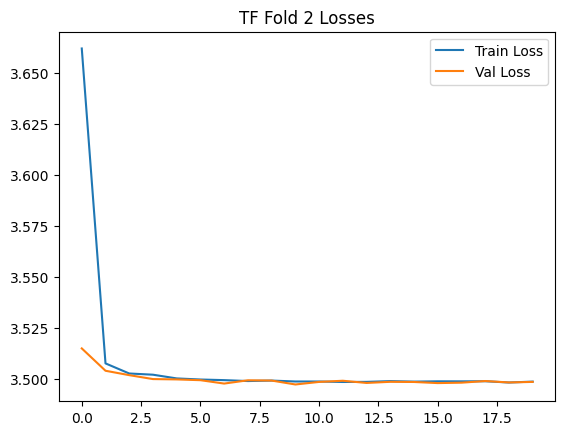

TF Fold 3
Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.0291 - loss: 4.0174 - val_accuracy: 0.0311 - val_loss: 3.5332
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0285 - loss: 3.5223 - val_accuracy: 0.0264 - val_loss: 3.5095
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0270 - loss: 3.5073 - val_accuracy: 0.0264 - val_loss: 3.5053
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0295 - loss: 3.5058 - val_accuracy: 0.0301 - val_loss: 3.5035
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0280 - loss: 3.5031 - val_accuracy: 0.0245 - val_loss: 3.5008
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0295 - loss: 3.5009 - val_accuracy: 0.0280 - val_loss: 3.4998
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0270 - loss: 3.5001 - val_accuracy: 0.0245 - val_loss: 3.5003
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0309 - loss: 3

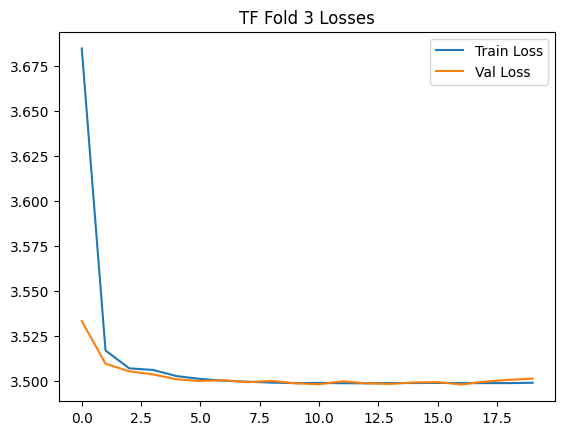

TF Fold 4
Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.0325 - loss: 3.9747 - val_accuracy: 0.0260 - val_loss: 3.5217
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0284 - loss: 3.5160 - val_accuracy: 0.0284 - val_loss: 3.5067
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0301 - loss: 3.5054 - val_accuracy: 0.0289 - val_loss: 3.5034
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.0322 - loss: 3.5025 - val_accuracy: 0.0286 - val_loss: 3.4997
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.0284 - loss: 3.5011 - val_accuracy: 0.0291 - val_loss: 3.5002
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.0274 - loss: 3.5000 - val_accuracy: 0.0274 - val_loss: 3.5010
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.0318 - loss: 3.4992 - val_accuracy: 0.0299 - val_loss: 3.4989
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0302 - loss:

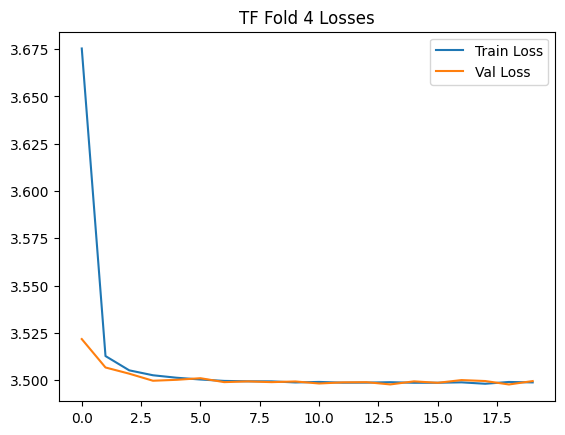

TF Fold 5
Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.0282 - loss: 4.1805 - val_accuracy: 0.0268 - val_loss: 3.5385
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.0308 - loss: 3.5280 - val_accuracy: 0.0299 - val_loss: 3.5112
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0351 - loss: 3.5085 - val_accuracy: 0.0321 - val_loss: 3.5075
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0294 - loss: 3.5051 - val_accuracy: 0.0287 - val_loss: 3.5047
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.0305 - loss: 3.5020 - val_accuracy: 0.0286 - val_loss: 3.5018
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0274 - loss: 3.5018 - val_accuracy: 0.0280 - val_loss: 3.5015
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.0276 - loss: 3.4998 - val_accuracy: 0.0268 - val_loss: 3.5002
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0300 - loss: 3

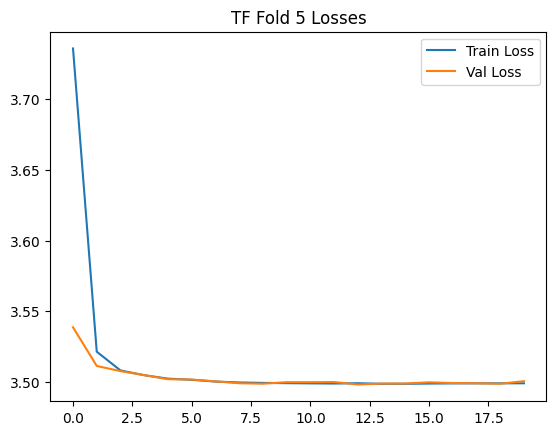

TF Mean Accuracy: 0.028282828256487848


In [8]:
X = np.load('/content/X.npy').reshape(-1, 32, 32, 1)
y = np.load('/content/y.npy')

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05
)

def create_model(hidden1=128, hidden2=64):
    model = Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 1)),
        Dense(hidden1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(hidden2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(33, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies_tf = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'TF Fold {fold+1}')
    X_train_fold, y_train_fold = X[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X[val_idx], y[val_idx]

    model = create_model()

    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=64),
                        epochs=20,
                        validation_data=(X_val_fold, y_val_fold),
                        verbose=1)

    _, acc = model.evaluate(X_val_fold, y_val_fold)
    accuracies_tf.append(acc)
    print(f'Accuracy: {acc}')

    # Plot losses
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'TF Fold {fold+1} Losses')
    plt.legend()
    plt.show()

print(f'TF Mean Accuracy: {np.mean(accuracies_tf)}')

model.save('/content/tensorflow_model.h5')